In [1]:
from zipfile import ZipFile

zip_path = "/content/images.zip"


extract_path = "/content/i"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping completed!")

Unzipping completed!


Lstm

In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

sentiment_df = pd.read_csv("/content/sentiment_data.csv")

sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)


text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = LSTM(64)(x_txt)


combined = Concatenate()([x_img, x_txt])


identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)


model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])

model.compile(
    optimizer='adam',
    loss={
        'identity_output': 'categorical_crossentropy',
        'sentiment_output': 'categorical_crossentropy'
    },
    metrics={
        'identity_output': 'accuracy',
        'sentiment_output': 'accuracy'
    }
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")

    img_batch, id_batch = next(train_gen)


    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)

    history = model.fit(
        [img_batch, repeated_padded_sequences],
        {
            'identity_output': id_batch,
            'sentiment_output': repeated_sentiment_labels
        },
        epochs=1,
        verbose=1
    )


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


/tmp/ipython-input-9-1841467296.py:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - identity_output_accuracy: 0.2500 - identity_output_loss: 1.5767 - loss: 2.6837 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_loss: 1.1070
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - identity_output_accuracy: 0.7500 - identity_output_loss: 0.5939 - loss: 1.6446 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 1.0507
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.2330 - loss: 1.2247 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9917
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0481 - loss: 0.9727 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9245
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 0.7500 - identity_output_loss: 0.5968 - loss: 1.4415 - sentiment_output_accuracy: 1.0000 - sent

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}

sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}


def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)


def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded


def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)

    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label


In [11]:
def predict_identity_and_sentiment(img_path, text_input):

    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)

    preds = model.predict([img_input, text_input_padded])


    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])


    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label


In [12]:
image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG-20230912-WA0019 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Name: Jothi
Predicted Sentiment: positive


In [13]:
image_path = "/content/i/sentiment_images[1]/train/Mahadevan/happy/IMG20250408121637 - Copy (2).jpg"
text_input = "I am so tired and upset."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Name: Mahadevan
Predicted Sentiment: positive


Predicted Name: Mahadevan
Predicted Sentiment: positive


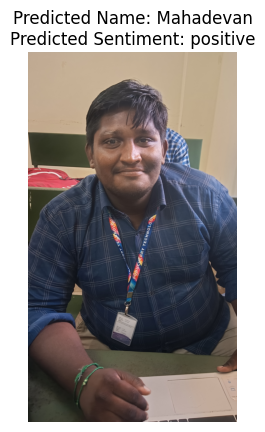

In [14]:
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

# Display the image along with predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Name: {name_pred}\nPredicted Sentiment: {sentiment_pred}")
plt.show()

RNN

In [5]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image

sentiment_df = pd.read_csv("/content/sentiment_data.csv")
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)

text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = SimpleRNN(64)(x_txt)

combined = Concatenate()([x_img, x_txt])

identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)

model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])
model.compile(
    optimizer='adam',
    loss={'identity_output': 'categorical_crossentropy', 'sentiment_output': 'categorical_crossentropy'},
    metrics={'identity_output': 'accuracy', 'sentiment_output': 'accuracy'}
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")
    img_batch, id_batch = next(train_gen)
    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)

    history = model.fit(
        [img_batch, repeated_padded_sequences],
        {'identity_output': id_batch, 'sentiment_output': repeated_sentiment_labels},
        epochs=1,
        verbose=1
    )

class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}
sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded

def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)
    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label

image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101814 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


/tmp/ipython-input-5-403868235.py:52: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - identity_output_accuracy: 0.2500 - identity_output_loss: 1.1065 - loss: 2.1512 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 1.0447
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - identity_output_accuracy: 0.7500 - identity_output_loss: 0.7028 - loss: 1.4615 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.7587
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0199 - loss: 0.5487 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.5288
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0805 - loss: 0.4362 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.3557
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.1140 - loss: 0.3511 - sentiment_output_accuracy: 1.0000 - sentimen

In [6]:
image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101828 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Predicted Name: Jothi
Predicted Sentiment: positive


Predicted Name: Jothi
Predicted Sentiment: positive


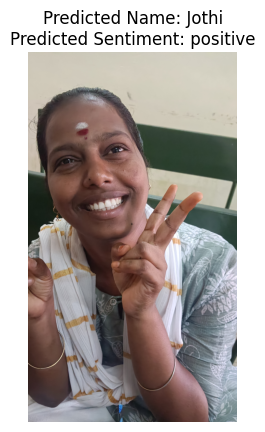

In [7]:
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

# Display the image along with predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Name: {name_pred}\nPredicted Sentiment: {sentiment_pred}")
plt.show()

GRU

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image


sentiment_df = pd.read_csv("/content/sentiment_data.csv")

sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
sentiment_df['sentiment'] = sentiment_df['sentiment'].map(sentiment_map)

texts = sentiment_df['text'].tolist()
sentiments = to_categorical(sentiment_df['sentiment'], num_classes=3)


tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

img_size = (224, 224)
batch_size = 8

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    '/content/i/sentiment_images[1]/validation',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


image_input = Input(shape=(224, 224, 3), name="image_input")
cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)
x_img = GlobalAveragePooling2D()(cnn_base.output)


text_input = Input(shape=(max_seq_len,), name="text_input")
x_txt = Embedding(input_dim=vocab_size, output_dim=128)(text_input)
x_txt = GRU(64)(x_txt)

combined = Concatenate()([x_img, x_txt])


identity_output = Dense(train_gen.num_classes, activation='softmax', name='identity_output')(combined)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(x_txt)


model = Model(inputs=[image_input, text_input], outputs=[identity_output, sentiment_output])

model.compile(
    optimizer='adam',
    loss={
        'identity_output': 'categorical_crossentropy',
        'sentiment_output': 'categorical_crossentropy'
    },
    metrics={
        'identity_output': 'accuracy',
        'sentiment_output': 'accuracy'
    }
)

num_batches = len(train_gen)

for batch_index in range(num_batches):
    print(f"Training batch {batch_index + 1}/{num_batches}")

    img_batch, id_batch = next(train_gen)


    repeated_padded_sequences = np.repeat([padded_sequences[0]], repeats=img_batch.shape[0], axis=0)
    repeated_sentiment_labels = np.repeat([sentiments[0]], repeats=img_batch.shape[0], axis=0)


    model.fit(
        [img_batch, repeated_padded_sequences],
        {
            'identity_output': id_batch,
            'sentiment_output': repeated_sentiment_labels
        },
        epochs=1,
        verbose=1
    )


class_indices = train_gen.class_indices
idx_to_name = {v: k for k, v in class_indices.items()}
sentiment_map_reverse = {0: 'positive', 1: 'negative', 2: 'neutral'}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def preprocess_text(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    return padded

def predict_identity_and_sentiment(img_path, text_input):
    img_input = preprocess_image(img_path)
    text_input_padded = preprocess_text(text_input, tokenizer)
    preds = model.predict([img_input, text_input_padded])

    identity_pred = np.argmax(preds[0])
    sentiment_pred = np.argmax(preds[1])

    identity_name = idx_to_name[identity_pred]
    sentiment_label = sentiment_map_reverse[sentiment_pred]

    return identity_name, sentiment_label

image_path = "/content/i/sentiment_images[1]/train/Jothi/happy/IMG20250408101814 - Copy.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)


Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


/tmp/ipython-input-2-2515355833.py:55: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=image_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training batch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - identity_output_accuracy: 0.3750 - identity_output_loss: 1.4639 - loss: 2.5667 - sentiment_output_accuracy: 0.0000e+00 - sentiment_output_loss: 1.1028
Training batch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.3368 - loss: 1.3781 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 1.0413
Training batch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0935 - loss: 1.0727 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9792
Training batch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - identity_output_accuracy: 1.0000 - identity_output_loss: 0.0084 - loss: 0.9235 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.9151
Training batch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - identity_output_accuracy: 0.8750 - identity_output_loss: 0.4766 - loss: 

In [3]:
image_path = "/content/i/sentiment_images[1]/train/Mahadevan/sad/IMG20250408121708_01.jpg"
text_input = "I love this moment!."

name_pred, sentiment_pred = predict_identity_and_sentiment(image_path, text_input)

print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Name: Mahadevan
Predicted Sentiment: positive


Predicted Name: Mahadevan
Predicted Sentiment: positive


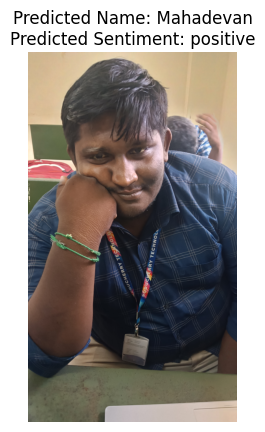

In [4]:
print("Predicted Name:", name_pred)
print("Predicted Sentiment:", sentiment_pred)

# Display the image along with predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Name: {name_pred}\nPredicted Sentiment: {sentiment_pred}")
plt.show()

resnet based sentiment prediction and use  generative models for sentiment emoji

Using device: cuda
Emotion Classes: ['happy', 'neutral', 'sad']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.6146
Epoch 2/5, Loss: 0.4085
Epoch 3/5, Loss: 0.2557
Epoch 4/5, Loss: 0.1417
Epoch 5/5, Loss: 0.0875
✅ Model saved to emotion_model.pth


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Predicted Emotion: happy


  0%|          | 0/50 [00:00<?, ?it/s]

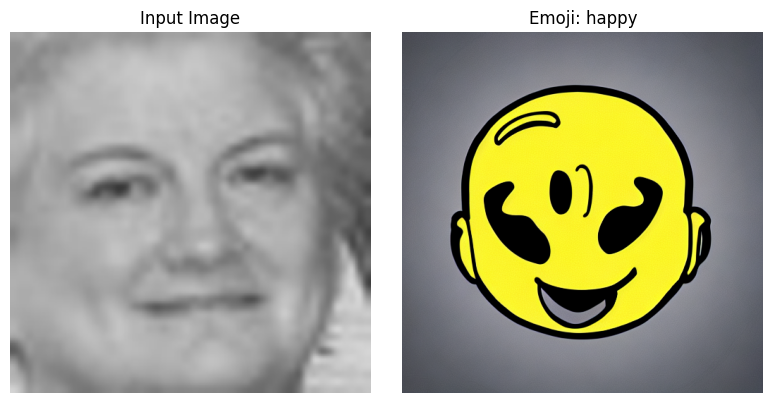

Saved emoji to emoji_happy.png


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dir   = "/content/i/images/train"
val_dir     = "/content/i/images/validation"
model_path  = "emotion_model.pth"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)


emotion_labels = train_ds.classes
print("Emotion Classes:", emotion_labels)
num_classes = len(emotion_labels)


def get_model(n_classes):
    m = models.resnet18(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, n_classes)
    return m.to(device)

model = get_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train_and_save(epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg:.4f}")
    torch.save(model.state_dict(), model_path)
    print("✅ Model saved to", model_path)


train_and_save(epochs=5)


pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to(device)


def load_image_tensor(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

def predict_emotion(path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    tensor = load_image_tensor(path)
    with torch.no_grad():
        logits = model(tensor)
        idx = torch.argmax(logits, dim=1).item()
    return emotion_labels[idx]

def generate_emoji(emotion):
    prompt = f"emoji of a {emotion} person, cartoon, simple, expressive"
    return pipe(prompt).images[0]


def run_sentiment_to_emoji(image_path):
    emotion = predict_emotion(image_path)
    print("Predicted Emotion:", emotion)

    emoji_img = generate_emoji(emotion)


    orig = Image.open(image_path).convert("RGB").resize((224,224))
    fig, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(orig)
    axs[0].set_title("Input Image"); axs[0].axis("off")
    axs[1].imshow(emoji_img)
    axs[1].set_title(f"Emoji: {emotion}"); axs[1].axis("off")
    plt.tight_layout()
    plt.show()


    out = f"emoji_{emotion}.png"
    emoji_img.save(out)
    print("Saved emoji to", out)


run_sentiment_to_emoji("/content/i/images/train/happy/100.jpg")



Predicted Emotion: neutral


  0%|          | 0/50 [00:00<?, ?it/s]

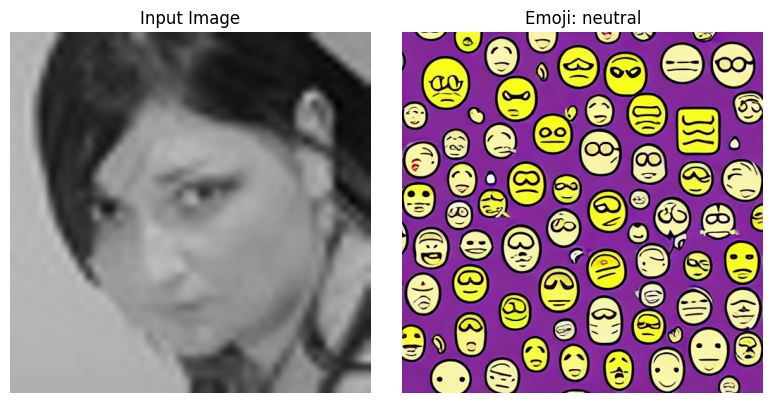

Saved emoji to emoji_neutral.png


In [19]:
run_sentiment_to_emoji("/content/i/images/train/neutral/10816.jpg")

Predicted Emotion: sad


  0%|          | 0/50 [00:00<?, ?it/s]

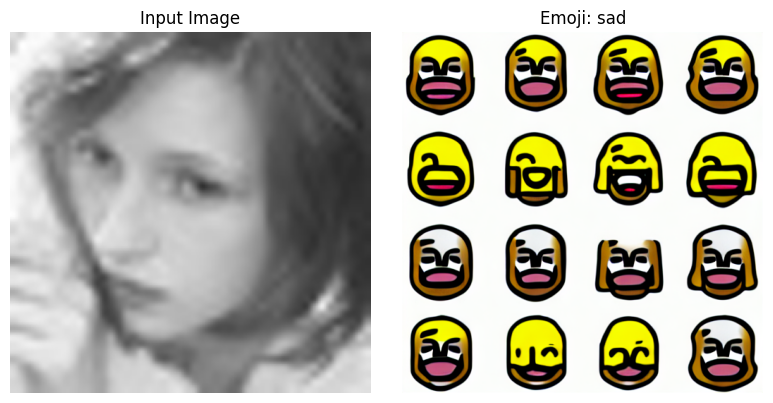

Saved emoji to emoji_sad.png


In [20]:
run_sentiment_to_emoji("/content/i/images/train/sad/10498.jpg")

VIT-BASED SENTIMENT PREDICTION AND USE OF DIFFUSION MODEL TO GENERATE A EMOJI BASED SENTIMENT TEXT

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from PIL import Image
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


train_dir = "/content/i/images/train"
val_dir = "/content/i/images/validation"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


emotion_labels = train_dataset.classes
num_classes = len(emotion_labels)
print("Emotion Classes:", emotion_labels)


config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.num_labels = num_classes


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    config=config,
    ignore_mismatched_sizes=True
)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

def train(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


    torch.save(model.state_dict(), "vit_emotion_model.pth")
    print("Model saved.")


train(model, train_loader, val_loader, epochs=3)


def predict_emotion(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=image).logits
        _, predicted = torch.max(outputs, 1)

    predicted_class = emotion_labels[predicted.item()]
    print(f"Predicted Emotion: {predicted_class}")
    return predicted_class


test_img = "/content/i/images/train/happy/100.jpg"
predict_emotion(test_img)


Using device: cuda
Emotion Classes: ['happy', 'neutral', 'sad']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 1068/1068 [09:59<00:00,  1.78it/s]


Epoch 1 Loss: 0.5127


Epoch 2/3: 100%|██████████| 1068/1068 [10:01<00:00,  1.78it/s]


Epoch 2 Loss: 0.3415


Epoch 3/3: 100%|██████████| 1068/1068 [10:01<00:00,  1.78it/s]


Epoch 3 Loss: 0.2035
Model saved.
Predicted Emotion: happy


'happy'

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Predicted Emotion: happy


  0%|          | 0/50 [00:00<?, ?it/s]

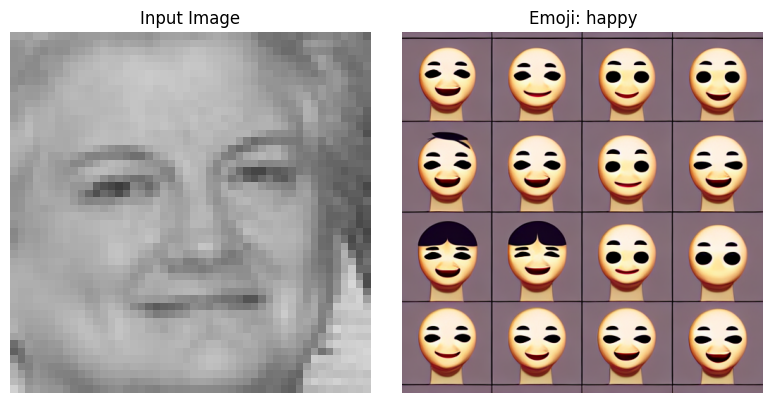

In [3]:
import torch
from torchvision import transforms
from transformers import ViTForImageClassification, ViTConfig
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

emotion_labels = ['happy', 'neutral', 'sad']
num_classes = len(emotion_labels)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.num_labels = num_classes

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    config=config,
    ignore_mismatched_sizes=True
)
model.load_state_dict(torch.load("/content/vit_emotion_model.pth", map_location=device))
model.to(device)
model.eval()


pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to(device)



def load_image_tensor(image_path):
    img = Image.open(image_path).convert("RGB")
    return transform(img).unsqueeze(0).to(device)

def predict_emotion(image_tensor):
    with torch.no_grad():
        logits = model(pixel_values=image_tensor).logits
        idx = torch.argmax(logits, dim=1).item()
    return emotion_labels[idx]

def generate_emoji(emotion):
    prompt = f"emoji of a {emotion} cartoon face, expressive, cute, simple"
    image = pipe(prompt).images[0]
    return image


def run_sentiment_to_emoji(image_path):

    img_tensor = load_image_tensor(image_path)
    pred_emotion = predict_emotion(img_tensor)
    print(f"Predicted Emotion: {pred_emotion}")

    emoji_img = generate_emoji(pred_emotion)
    original_img = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(emoji_img)
    plt.title(f"Emoji: {pred_emotion}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


test_image_path = "/content/i/images/train/happy/100.jpg"
run_sentiment_to_emoji(test_image_path)


Predicted Emotion: neutral


  0%|          | 0/50 [00:00<?, ?it/s]

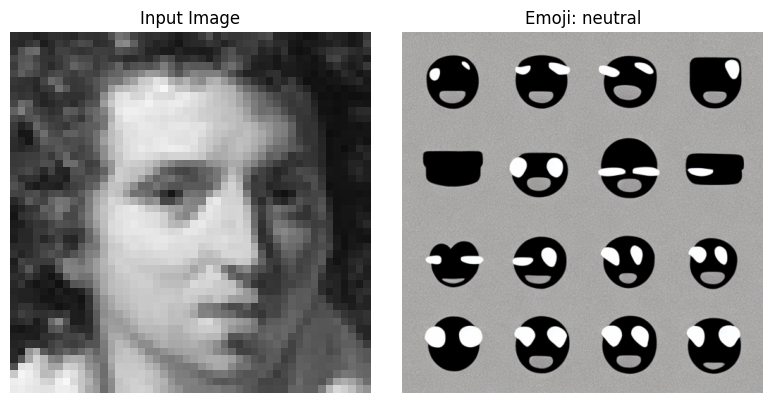

In [4]:
test_image_path = "/content/i/images/train/neutral/1000.jpg"
run_sentiment_to_emoji(test_image_path)

Predicted Emotion: sad


  0%|          | 0/50 [00:00<?, ?it/s]

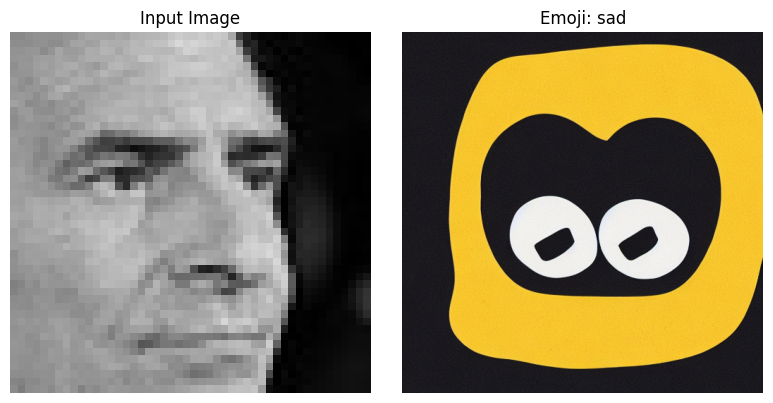

In [5]:
test_image_path = "/content/i/images/train/sad/10006.jpg"
run_sentiment_to_emoji(test_image_path)